In [486]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from utils import get_data, get_probabilities, estimate_q_Z_given_A, get_probabilities_one_hot
from sklearn.decomposition import NMF  # Placeholder for volmin factorization
from volmin_nmf import *
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from scipy.optimize import nnls

In [487]:
debug = True

In [488]:
p_source = 0.8
p_target = 0.2
total = 10000
factorisation_atol = 1e-1

# Step 2 parameters
specific_a_index = 0  # First value of A

# "sklearn" for sklearn's NMF
# "volmin_1" for volmin NMF, adapted from https://github.com/kharchenkolab/vrnmf
# "volmin_2" for volmin NMF, adapted from https://github.com/bm424/mvcnmf/blob/master/mvcnmf.py
nmf_method = "volmin_2" 
# parameters for volmin NMF
w_vol = 0.01#0.1
delta = 1e-8
n_iter = 200000
err_cut = 1e-10

np.random.seed(0)
torch.manual_seed(0)

In [489]:
# 2x2 matrix
theta_w_epsilon = torch.tensor([
    # [-1, 1],
    # [1, -1]
    [-2, 2],
    [2, -2]
])

# 2x2 matrix
theta_z_epsilon = torch.tensor([
    # [1, -1],
    # [-1, 1]
    [-2, 2],
    [2, -2]
])

theta_a_z_epsilon = torch.tensor([
    # [1, -1],
    # [-1, 1],
    # [1, -1]

    # [1.0, -1.0],  # Increased magnitude for more variability
    # [-3.0, 3.0],
    # [3.0, -3.0]

    [2.0, -2.0],  
    [-2.0, 2.0],
    [2.0, -2.0]

    # [1.0, -1.0],  
    # [-1.0, 1.0],
    # [1.0, -1.0]
]) #negate when epsilon is 1

# 1x5 matrix concatenating 1 hot of w and a. Negate when epsilon is 1. a is 3D and w is 2D
theta_y_a_w_epsilon = torch.tensor([
    # [3, 2, -1, -1, 1]
    # [3, 1, -2, -1, 1]
    # [30, 5, -20, -10, 10] # larger values seem to push the sigmoid to the extremes
    # [10, 5, -10, -10, 10]
    # [15, 10, -15, -10, 10]
    # [20, 5, -20, -10, 10] # larger values seem to push the sigmoid to the extremes
    # [3, 3, -4, -2, 1] 
    # [5, 2, -1, -1, 1]
    [10, 3, -5, -3, 3]
]) 


In [490]:
def get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p=0.2):
    epsilon = torch.bernoulli(torch.tensor([p])).long() # (1,)
    epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)

    # z = np.sign(epsilon_one_hot@theta_z_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)
    # w = np.sign(epsilon_one_hot@theta_w_epsilon) # discrete so categorical depending on epsilon (paper has Normal as cont)
    z = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_z_epsilon)).float().squeeze()
    w = torch.bernoulli(torch.sigmoid(epsilon_one_hot @ theta_w_epsilon)).float().squeeze() # w given z and a should be perfect

    # w given z and a should be perfect

    a_logits = epsilon * theta_a_z_epsilon.float() @ z.float() + (epsilon-1) * theta_a_z_epsilon.float() @ z.float() #epsilon is 0 or 1, theta_a_z_epsilon is 3x2, z is [2]. So result is 3x1
    a_prob = torch.softmax(a_logits, dim=0)  # Apply softmax to convert logits to probabilities
    if debug:
        print(a_prob)   
    a_category = torch.multinomial(a_prob, 1).squeeze()  # Sample from the categorical distribution
    a = torch.nn.functional.one_hot(a_category, num_classes=3).float()  # Convert to one-hot encoding
    if debug:
        print(a)
    # a = torch.bernoulli(torch.sigmoid(a_logits)).float().squeeze() # a is size 3

    # concatenate w and a
    # then similar but use different matrix and w,a instead of z
    wa = torch.cat((w, a), dim=0) # [5]

    y_logits = epsilon * theta_y_a_w_epsilon @ wa.long() + (epsilon-1) * theta_y_a_w_epsilon @ wa.long() # y is a function of a, w and epsilon from the graph
    #print(torch.sigmoid(y_logits))
    y = torch.bernoulli(torch.sigmoid(y_logits).squeeze()).float()

    return epsilon,z,w,a,y

def get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p, total):
    U,Z,W,X,Y = [],[],[],[],[]
    for _ in range(total):
        u,z,w,x,y = get_tuple_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p)
        U.append(u)
        Z.append(z)
        W.append(w)
        X.append(x)
        Y.append(y)

    return U,Z,W,X,Y

def get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total):
    
    # Source distribution data
    U_source, Z_source, W_source, X_source, Y_source = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, total)
    
    # Target distribution data
    U_target, Z_target, W_target, X_target, Y_target = get_dataset_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_target, total)
    
    return (Z_source, U_source, W_source, X_source, Y_source), \
           (Z_target, U_target, W_target, X_target, Y_target)

In [491]:
source_data, target_data = get_data_new(theta_w_epsilon,theta_z_epsilon,theta_a_z_epsilon,theta_y_a_w_epsilon, p_source, p_target, total)
Z_source, epsilon_source, W_source, A_source, Y_source = source_data
Z_target, epsilon_target, W_target, A_target, Y_target = target_data


/var/folders/tf/g242212x4tsbkxq6k9xkfvn80000gn/T/ipykernel_93154/257846156.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  epsilon_one_hot = torch.nn.functional.one_hot(torch.tensor(epsilon), num_classes=2).squeeze() # (1,2)


tensor([0.3333, 0.3333, 0.3333])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([0., 0., 1.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.3333, 0.3333, 0.3333])
tensor([0., 0., 1.])
tensor([0.3333, 0.3333, 0.3333])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.4955])
tensor([1., 0., 0.])
tensor([0.4955, 0.0091, 0.49

In [492]:
if debug:
    A_source

In [493]:
# Split source data into training, validation, and test sets
A_train_val_source, A_test_source, Z_train_val_source, Z_test_source, W_train_val_source, W_test_source, Y_train_val_source, Y_test_source, epsilon_train_val_source, epsilon_test_source = train_test_split(
    A_source, Z_source, W_source, Y_source, epsilon_source, test_size=0.2, random_state=42)
A_train_source, A_val_source, Z_train_source, Z_val_source, W_train_source, W_val_source, Y_train_source, Y_val_source, epsilon_train_source, epsilon_val_source = train_test_split(
    A_train_val_source, Z_train_val_source, W_train_val_source, Y_train_val_source, epsilon_train_val_source, test_size=0.25, random_state=42)



In [494]:
# Split target data into training, validation, and test sets
A_train_val_target, A_test_target, Z_train_val_target, Z_test_target, W_train_val_target, W_test_target, Y_train_val_target, Y_test_target, epsilon_train_val_target, epsilon_test_target = train_test_split(
    A_target, Z_target, W_target, Y_target, epsilon_target, test_size=0.2, random_state=42)
A_train_target, A_val_target, Z_train_target, Z_val_target, W_train_target, W_val_target, Y_train_target, Y_val_target, epsilon_train_target, epsilon_val_target = train_test_split(
    A_train_val_target, Z_train_val_target, W_train_val_target, Y_train_val_target, epsilon_train_val_target, test_size=0.25, random_state=42)


In [495]:
# So the sets are of the form:
# Training: A_train_source
# Validation: A_val_source
# Test: A_test_source

In [496]:
if debug:
    sum(Y_source)

In [497]:
if debug:
    print("Y_source.shape", len(Y_source))
    print("W_source.shape", len(W_source))
    print("A_source.shape", len(A_source))
    print("Z_source.shape", len(Z_source))
    print("epsilon_source.shape", len(epsilon_source))

    print("Y_source", Y_source)
    print("W_source", W_source)
    print("A_source", A_source)
    print("Z_source", Z_source)
    print("epsilon_source", epsilon_source)

Y_source.shape 10000
W_source.shape 10000
A_source.shape 10000
Z_source.shape 10000
epsilon_source.shape 10000
Y_source [tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), ten

In [498]:
# def plot_histograms(data, label):
#     Z, epsilon, W, A, Y = data

#     # Convert tensors to numpy arrays
#     Z_np = np.array(Z)
#     epsilon_np = np.array(epsilon)
#     W_np = np.array(W)
#     A_np = np.array(A)
#     Y_np = np.array(Y)

#     # Flatten the arrays for histogram plotting
#     Z_flat = Z_np.flatten()
#     epsilon_flat = epsilon_np.flatten()
#     W_flat = W_np.flatten()
#     A_flat = A_np.flatten()
#     Y_flat = Y_np.flatten()

#     # Plot histograms
#     plt.figure(figsize=(10, 5))

#     plt.subplot(2, 3, 1)
#     plt.hist(Z_flat, bins=20, color='blue', alpha=0.7)
#     plt.title(f'Histogram of Z_{label}')

#     plt.subplot(2, 3, 2)
#     plt.hist(epsilon_flat, bins=20, color='green', alpha=0.7)
#     plt.title(f'Histogram of epsilon_{label}')

#     plt.subplot(2, 3, 3)
#     plt.hist(W_flat, bins=20, color='red', alpha=0.7)
#     plt.title(f'Histogram of W_{label}')

#     plt.subplot(2, 3, 4)
#     plt.hist(A_flat, bins=20, color='purple', alpha=0.7)
#     plt.title(f'Histogram of A_{label}')

#     plt.subplot(2, 3, 5)
#     plt.hist(Y_flat, bins=20, color='orange', alpha=0.7)
#     plt.title(f'Histogram of Y_{label}')

#     plt.tight_layout()
#     plt.show()


In [499]:
num_classes_Y = 2 
num_classes_W = 2
num_features_Z = 2
num_features_A = 3

sum_epsilon = np.sum(epsilon_source)
if debug:
    print("Sum of epsilon_source:", sum_epsilon.item())

sum_Y = np.sum(Y_source)
if debug:
    print("Sum of Y_source:", sum_Y.item())

Sum of epsilon_source: 8054
Sum of Y_source: 8321.0


In [500]:
# =============================================================================
# Step 1: Estimate p(Y|Z,a) and p(W|Z,a)
# =============================================================================

# Train model to estimate p(Y|Z,a)
# By stacking with A, we condition on A by including all values of A in the input

# AMENDED TO USE TRAIN TEST SPLIT
ZA_source = np.hstack((Z_train_source, A_train_source)) 
# ZA_source = np.hstack((Z_source, A_source)) 


# if step1_debug:
#     print("ZA_source.shape", ZA_source.shape)  # Debug print statement
#     print("ZA_source", ZA_source)  # Debug print statement

############### LOGISTIC REGRESSION VERSION ###############

#model_Y = LogisticRegression(input_dim=ZA_source.shape[1], num_classes=2)
#model_Y.train(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32))

# model_Y = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=Y_source.shape[1])
# model_Y.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)
# p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)

In [501]:
# Y_source = torch.stack(Y_source).long()

In [502]:
############### SKLEARN VERSION ###############

# print("Y_source flatten", Y_source.flatten())
ZA_source



##### LOGISTIC REGRESSION #####
model_Y = SklearnLogisticRegression(max_iter=1000)
model_Y.fit(ZA_source, Y_train_source)
########AMENDED TO INCLUDE TRAIN TEST###########
#model_Y.fit(ZA_source, Y_source)



##### GRAIDENT BOOSTING #####
# model_Y = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=0)
# model_Y.fit(ZA_source, Y_train_source)

##### RANDOM FOREST #####
# model_Y = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
# model_Y.fit(ZA_source, Y_train_source)

##### NEURAL NETWORK #####
# model_Y = MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000)
# model_Y.fit(ZA_source, Y_train_source)

if debug:
    print(ZA_source)
    print(Y_source)
Y_train_pred = model_Y.predict(ZA_source)
if debug:
    print("Y_train_pred",Y_train_pred)

#AMENDED FOR TRAIN TEST
# Y_train_true = Y_source
# accuracy_Y_train = np.mean(Y_train_pred == Y_source)
Y_train_true = Y_train_source
accuracy_Y_train = np.mean(Y_train_pred == Y_train_source)
print(f"Accuracy of model_Y on training set: {accuracy_Y_train:.4f}")


[[1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 ...
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1.]]
[tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.

In [503]:
cm = confusion_matrix(Y_train_source, model_Y.predict(ZA_source))
if debug:
    print("Classification Report:")
    print(classification_report(Y_train_source, model_Y.predict(ZA_source)))

# AMENDED FOR TRAIN TEST SPLIT
# cm = confusion_matrix(Y_source, model_Y.predict(ZA_source))
# print("Classification Report:")
# print(classification_report(Y_source, model_Y.predict(ZA_source)))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60      1019
         1.0       0.89      1.00      0.94      4981

    accuracy                           0.90      6000
   macro avg       0.95      0.71      0.77      6000
weighted avg       0.91      0.90      0.89      6000



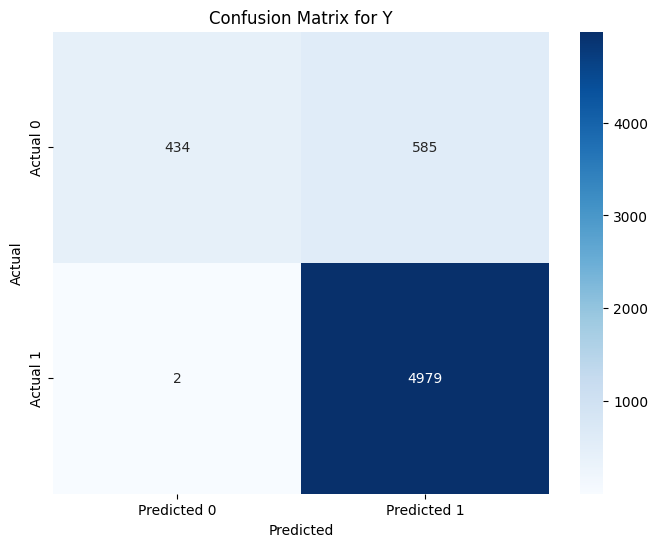

In [504]:
if debug:    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y')
    plt.show()

Y_val_pred: [1. 0. 1. ... 1. 1. 1.]
Accuracy of model_Y on validation set: 0.9075
Confusion Matrix (Validation):
[[ 148  184]
 [   1 1667]]
Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.99      0.45      0.62       332
         1.0       0.90      1.00      0.95      1668

    accuracy                           0.91      2000
   macro avg       0.95      0.72      0.78      2000
weighted avg       0.92      0.91      0.89      2000



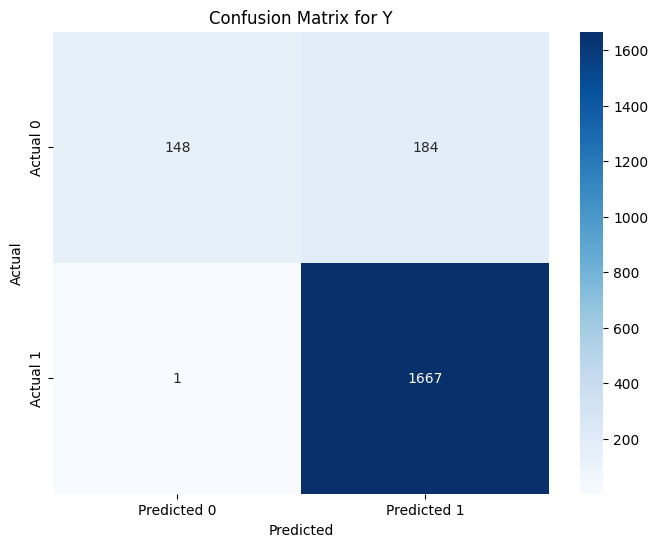

In [505]:
if debug:    
    # VALIDATION SET
    # Combine Z and A for the validation set
    ZA_source_validation = np.hstack((Z_val_source, A_val_source)) 

    # Predict Y on the validation set
    Y_val_pred = model_Y.predict(ZA_source_validation)
    print("Y_val_pred:", Y_val_pred)

    # True Y values for the validation set
    Y_val_true = Y_val_source

    # Calculate accuracy on the validation set
    accuracy_Y_val = np.mean(Y_val_pred == Y_val_true)
    print(f"Accuracy of model_Y on validation set: {accuracy_Y_val:.4f}")
    # Calculate confusion matrix for the validation set
    cm_val = confusion_matrix(Y_val_true, Y_val_pred)
    print("Confusion Matrix (Validation):")
    print(cm_val)

    # Print classification report for the validation set
    print("Classification Report (Validation):")
    print(classification_report(Y_val_true, Y_val_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y')
    plt.show()

Y_test_pred: [1. 1. 1. ... 1. 1. 1.]
Accuracy of model_Y on test set: 0.9055
Confusion Matrix (Test):
[[ 140  188]
 [   1 1671]]
Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.99      0.43      0.60       328
         1.0       0.90      1.00      0.95      1672

    accuracy                           0.91      2000
   macro avg       0.95      0.71      0.77      2000
weighted avg       0.91      0.91      0.89      2000



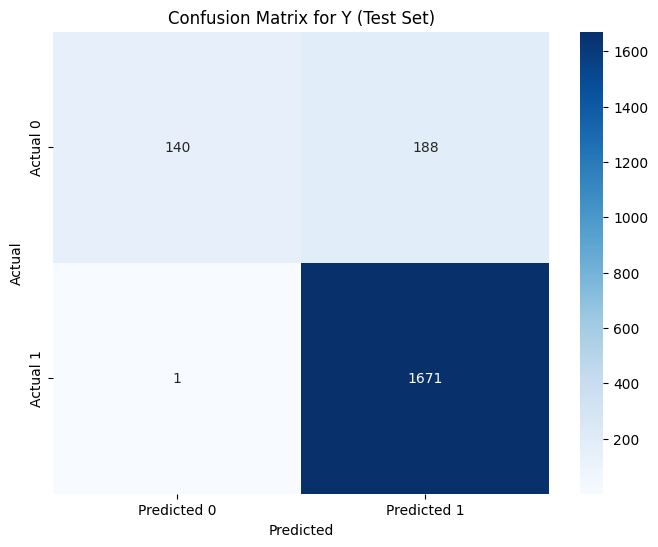

In [506]:
# TEST SET
# Combine Z and A for the test set
ZA_source_test = np.hstack((Z_test_source, A_test_source))

# Predict Y on the test set
Y_test_pred = model_Y.predict(ZA_source_test)
if debug:
    print("Y_test_pred:", Y_test_pred)

# True Y values for the test set
Y_test_true = Y_test_source

# Calculate accuracy on the test set
accuracy_Y_test = np.mean(Y_test_pred == Y_test_true)
if debug:
    print(f"Accuracy of model_Y on test set: {accuracy_Y_test:.4f}")

if debug:
    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(Y_test_true, Y_test_pred)
    print("Confusion Matrix (Test):")
    print(cm_test)

    # Print classification report for the test set
    print("Classification Report (Test):")
    print(classification_report(Y_test_true, Y_test_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Y (Test Set)')
    plt.show()


In [507]:
# def get_probabilities_one_hot_nn(model, Z, A):
#     """
#     Computes the softmax probabilities from the trained model.
    
#     Args:
#         model (model): Trained model.
#         Z (numpy.ndarray): Feature matrix Z.
#         A (numpy.ndarray): Feature matrix A.

#     Returns:
#         numpy.ndarray: Probability matrix reshaped to (|Z|, |A|, |Y|) or (|Z|, |A|, |W|).
#     """
#     num_Z = Z.shape[1]
#     num_A = A.shape[1]
#     num_classes = model.fc5.out_features #number of layers here

#     # Generate all possible one-hot vectors for Z
#     possible_Z = np.eye(num_Z)
#     possible_A = np.eye(num_A)
    
#     probabilities = []
    
#     for z in possible_Z:
#         for a in possible_A:
#             ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
#             ZA_tensor = torch.tensor(ZA, dtype=torch.float32)
#             with torch.no_grad():
#                 probs = model(ZA_tensor)
#                 probs = torch.softmax(probs, dim=1).numpy()
#                 probabilities.append(probs[0])
    
#     probabilities = np.array(probabilities).reshape((num_Z, num_A, num_classes))
    
#     return probabilities

In [508]:

# p_Y_given_ZA = get_probabilities_one_hot_nn(model_Y, Z_source, A_source)
# print("p_Y_given_ZA", p_Y_given_ZA)
# print("p_Y_given_ZA shape:", p_Y_given_ZA.shape)  # Debug print statement


In [509]:

# # Verify the shape of p_Y_given_ZA
# assert p_Y_given_ZA.shape == (num_features_Z, num_features_A, num_classes_Y), f"p_Y_given_ZA shape mismatch: {p_Y_given_ZA.shape}"
# assert np.allclose(p_Y_given_ZA.sum(axis=2), 1.0), "p_Y_given_ZA rows do not sum to 1"
# print("Step 1: p_Y_given_ZA shape and sum are correct.")



In [510]:
# W_source_indices = torch.argmax(torch.tensor(W_source), dim=1)
# print(W_source)
# print(W_source_indices)

In [511]:
#convert to binary

def tensor_to_binary(tensor):
    return 1 if tensor[0] == 1 else 0

# Convert the list of tensors to a list of binary labels
binary_labels = [tensor_to_binary(t) for t in W_train_source]

# Convert to numpy array (optional)
binary_labels_array = np.array(binary_labels)

In [512]:
############### LOGISTIC REGRESSION VERSION ###############
#Train model to estimate p(W|Z,a)
# model_W = LogisticRegressionGD(input_dim=ZA_source.shape[1], num_classes=W_source.shape[1])
# model_W.train_model(torch.tensor(ZA_source, dtype=torch.float32), torch.tensor(Y_source, dtype=torch.float32), learning_rate=0.01, epochs=100, verbose=True)

# p_W_given_ZA = get_probabilities_one_hot(model_W, Z_source, A_source)



############### SKLEARN VERSION ###############

# model_W = SklearnLogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
# model_W.fit(ZA_source, np.argmax(W_source, axis=1))
# W_train_pred = model_W.predict(ZA_source)
# W_train_true = np.argmax(W_source, axis=1)
# accuracy_W_train = np.mean(W_train_pred == W_train_true)
# print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")
#p_W_given_ZA = model_W.predict_proba(ZA_source).reshape(num_features_Z, num_features_A, num_classes_W)

model_W= SklearnLogisticRegression(max_iter=1000)
model_W.fit(ZA_source, binary_labels_array)

# print(ZA_source)
# print(W_source)
W_train_pred = model_W.predict(ZA_source)
if debug:
    print("W_train_pred",W_train_pred)

W_train_true = W_source
accuracy_W_train = np.mean(W_train_pred == binary_labels_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train:.4f}")



############### NEURAL NETWORK VERSION ###############

# Define and train the neural network
# input_dim = ZA_source.shape[1]
# model_W = SimpleNN(input_dim, num_classes_W)
# train_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices, learning_rate=0.001, epochs=500, batch_size=16)

# # Evaluate the model
# accuracy_nn = eval_nn(model_W, torch.tensor(ZA_source, dtype=torch.float32), W_source_indices)
# print(f'Accuracy of neural network model on training set: {accuracy_nn:.4f}')


W_train_pred [1 1 1 ... 1 1 1]
Accuracy of model_W on training set: 0.8412


In [513]:
cm_w = confusion_matrix(binary_labels_array, model_W.predict(ZA_source))
if debug:    
    print("Classification Report for W:")
    print(classification_report(binary_labels_array, model_W.predict(ZA_source)))

Classification Report for W:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63      1616
           1       0.84      0.97      0.90      4384

    accuracy                           0.84      6000
   macro avg       0.84      0.73      0.76      6000
weighted avg       0.84      0.84      0.83      6000



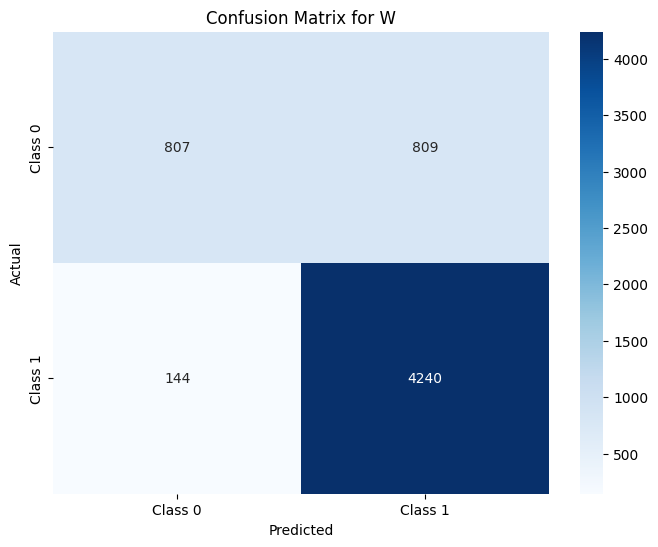

In [514]:
if debug:  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_w, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W')
    plt.show()

W_test_pred: [1 0 1 ... 1 1 0]
Accuracy of model_W on test set: 0.8250
Confusion Matrix (Test):
[[ 255  297]
 [  53 1395]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.46      0.59       552
           1       0.82      0.96      0.89      1448

    accuracy                           0.82      2000
   macro avg       0.83      0.71      0.74      2000
weighted avg       0.83      0.82      0.81      2000



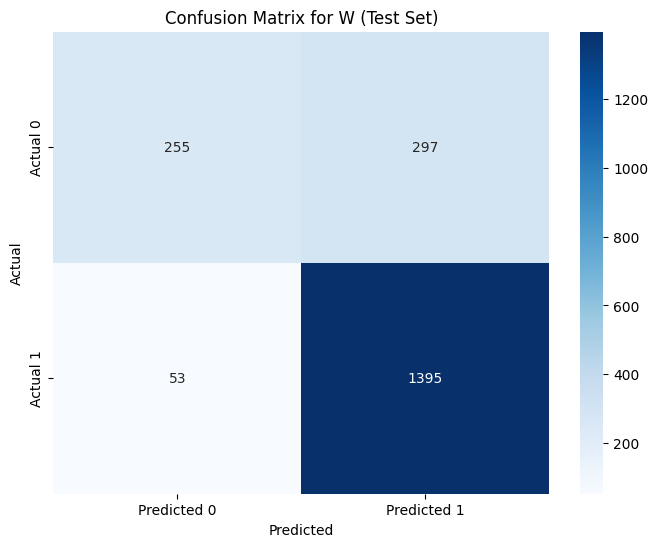

In [515]:
# Predict Y on the test set
W_test_pred = model_W.predict(ZA_source_test)
if debug:
    print("W_test_pred:", W_test_pred)

# True Y values for the test set
W_test_true = np.array([tensor_to_binary(t) for t in W_test_source])

# Calculate accuracy on the test set
accuracy_W_test = np.mean(W_test_pred == W_test_true)
print(f"Accuracy of model_W on test set: {accuracy_W_test:.4f}")

if debug:
    # Calculate confusion matrix for the test set
    cm_test_W = confusion_matrix(W_test_true, W_test_pred)
    print("Confusion Matrix (Test):")
    print(cm_test_W)

    # Print classification report for the test set
    print("Classification Report (Test):")
    print(classification_report(W_test_true, W_test_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test_W, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W (Test Set)')
    plt.show()


In [516]:
# p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)

# if step1_debug:
#     print("p_W_given_ZA shape:", p_W_given_ZA.shape)  # Debug print statement
#     print("p_W_given_ZA", p_W_given_ZA)  # Debug print statement

# # Verify the shape of p_W_given_ZA
# assert p_W_given_ZA.shape == (num_features_Z, num_features_A, num_classes_W), f"p_W_given_ZA shape mismatch: {p_W_given_ZA.shape}"
# assert np.allclose(p_W_given_ZA.sum(axis=2), 1.0), "p_W_given_ZA rows do not sum to 1"
# if step1_debug:
#     print("Step 1: p_W_given_ZA shape and sum are correct.")

# print("STEP 1 DONE")

In [517]:
if debug:
    np.array(binary_labels_array) # this is the true W
    np.array(epsilon_source).squeeze() # this is true epsilon
    count_W_0_eps_0 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_train_source).squeeze() == 0))
    count_W_1_eps_0 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_train_source).squeeze() == 0))
    count_W_0_eps_1 = np.sum((np.array(binary_labels_array) == 0) & (np.array(epsilon_train_source).squeeze() == 1))
    count_W_1_eps_1 = np.sum((np.array(binary_labels_array) == 1) & (np.array(epsilon_train_source).squeeze() == 1))
    print("Count W=0, epsilon=0:", count_W_0_eps_0)
    print("Count W=1, epsilon=0:", count_W_1_eps_0)
    print("Count W=0, epsilon=1:", count_W_0_eps_1)
    print("Count W=1, epsilon=1:", count_W_1_eps_1)

    # Total counts for eps = 0 and eps = 1
    total_eps_0 = np.sum(np.array(epsilon_train_source).squeeze() == 0)
    total_eps_1 = np.sum(np.array(epsilon_train_source).squeeze() == 1)

    # Calculate the probabilities
    P_W_0_given_eps_0 = count_W_0_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
    P_W_1_given_eps_0 = count_W_1_eps_0 / total_eps_0 if total_eps_0 > 0 else 0
    P_W_0_given_eps_1 = count_W_0_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
    P_W_1_given_eps_1 = count_W_1_eps_1 / total_eps_1 if total_eps_1 > 0 else 0
    print("P(W=0 | epsilon=0):", P_W_0_given_eps_0)
    print("P(W=1 | epsilon=0):", P_W_1_given_eps_0)
    print("P(W=0 | epsilon=1):", P_W_0_given_eps_1)
    print("P(W=1 | epsilon=1):", P_W_1_given_eps_1)


Count W=0, epsilon=0: 1063
Count W=1, epsilon=0: 118
Count W=0, epsilon=1: 553
Count W=1, epsilon=1: 4266
P(W=0 | epsilon=0): 0.9000846740050804
P(W=1 | epsilon=0): 0.09991532599491956
P(W=0 | epsilon=1): 0.11475409836065574
P(W=1 | epsilon=1): 0.8852459016393442


In [518]:
if debug:
    # First 5 entries of Z_source
    Z_source[:5]

In [519]:
if debug:
    # First 5 entries of A_source
    A_source[:5]

In [520]:
def get_probabilities(model, Z_source, A_source):

    # Convert lists of tensors to numpy arrays
    Z = np.array([z.numpy() for z in Z_source])
    A = np.array([a.numpy() for a in A_source])
    
    num_Z = Z.shape[1]
    num_A = A.shape[1]

    # Generate all possible one-hot vectors for Z and A
    possible_Z = np.eye(num_Z)
    possible_A = np.eye(num_A)
    
    probabilities = []
    
    for z in possible_Z:
        for a in possible_A:
            ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
            # Flatten ZA for the MLPClassifier
            ZA_flat = ZA.flatten().reshape(1, -1)
            prob = model.predict_proba(ZA_flat)[0]
            probabilities.append(prob)
    
    probabilities = np.array(probabilities).reshape((num_Z, num_A, 2))
    
    return probabilities

In [521]:
p_Y_given_ZA = get_probabilities(model_Y, Z_source, A_source)
print("This is p_Y_given_ZA, so for each possible Z and A")
print(p_Y_given_ZA)
p_Y_given_ZA_matrix = p_Y_given_ZA[:, specific_a_index, :]
print("")
print("")
print("This is p_Y_given_ZA, but for a specific A = a")
print(p_Y_given_ZA_matrix)

This is p_Y_given_ZA, so for each possible Z and A
[[[0.04494787 0.95505213]
  [0.04507842 0.95492158]
  [0.08025825 0.91974175]]

 [[0.4760971  0.5239029 ]
  [0.47685468 0.52314532]
  [0.62755333 0.37244667]]]


This is p_Y_given_ZA, but for a specific A = a
[[0.04494787 0.95505213]
 [0.4760971  0.5239029 ]]


In [522]:
p_W_given_ZA = get_probabilities(model_W, Z_source, A_source)
print("This is p_W_given_ZA, so for each possible Z and A")
print(p_W_given_ZA)
p_W_given_ZA_matrix = p_W_given_ZA[:, specific_a_index, :]
print("")
print("")
print("This is p_W_given_ZA, but for a specific A = a")
print(p_W_given_ZA_matrix)

This is p_W_given_ZA, so for each possible Z and A
[[[0.10196587 0.89803413]
  [0.05487081 0.94512919]
  [0.11497576 0.88502424]]

 [[0.79131988 0.20868012]
  [0.65973859 0.34026141]
  [0.81268865 0.18731135]]]


This is p_W_given_ZA, but for a specific A = a
[[0.10196587 0.89803413]
 [0.79131988 0.20868012]]


In [523]:
print("Step 1 done")

Step 1 done


In [524]:
# # p(w|epsilon = 0) and p(w|epsilon = 1) for source and target

# def compute_p_w_given_epsilon(W, epsilon):
#     # Combine W and epsilon into a single array
#     combined = np.column_stack((W, epsilon))
    
#     # Get unique pairs and their counts
#     unique_pairs, counts = np.unique(combined, axis=0, return_counts=True)
    
#     # Initialize the dictionary to hold p(w|epsilon)
#     p_w_given_epsilon = {}
    
#     # Calculate total counts for each value of epsilon
#     epsilon_values, epsilon_total_counts = np.unique(epsilon, return_counts=True)
#     epsilon_counts = dict(zip(epsilon_values, epsilon_total_counts))
    
#     for unique_pair, count in zip(unique_pairs, counts):
#         w = tuple(unique_pair[:-1])  # Extract W vector excluding epsilon
#         e = unique_pair[-1]  # Extract epsilon
#         if (e,) not in p_w_given_epsilon:
#             p_w_given_epsilon[(e,)] = {}
#         if w not in p_w_given_epsilon[(e,)]:
#             p_w_given_epsilon[(e,)][w] = 0
#         p_w_given_epsilon[(e,)][w] += count / epsilon_counts[e]
    
#     return p_w_given_epsilon

# # Prepare the data (convert tensors to numpy arrays)
# W_source_np = np.array([w.numpy() for w in W_source])
# epsilon_source_np = np.array([e.numpy() for e in epsilon_source]).squeeze()  # Ensure epsilon is 1D

# W_target_np = np.array([w.numpy() for w in W_target])
# epsilon_target_np = np.array([e.numpy() for e in epsilon_target]).squeeze()  # Ensure epsilon is 1D

# print("We want to compare this to the distribution extracted from the matrix factorisation")
# # Compute p(w|epsilon) for source data
# p_w_given_epsilon_source = compute_p_w_given_epsilon(W_source_np, epsilon_source_np)
# print("p(w|epsilon) for source data:", p_w_given_epsilon_source)

# # Compute p(w|epsilon) for target data
# p_w_given_epsilon_target = compute_p_w_given_epsilon(W_target_np, epsilon_target_np)
# print("p(w|epsilon) for target data:", p_w_given_epsilon_target)


In [525]:
stacked_matrix = np.vstack((p_Y_given_ZA_matrix, p_W_given_ZA_matrix)) # this should be a |Y| x |Z| matrix stacked on top of a |W| x |Z| matrix (for specific a)
if debug:
    stacked_matrix.T

In [526]:
# Determine the number of components for epsilon
num_epsilon = 2 # min(W_source.shape[1], Z_source.shape[1]) # Remember we need this to be less than the min of |W| and |Z|. Consider changing this as a hyperparameter

In [527]:
W, H = mvc_nmf(stacked_matrix.T, num_epsilon, w_vol, n_iter, err_cut) # Transpose the matrix to match the input format of the function

Converged with error difference 9.927574932365457e-07


In [528]:
if debug:
    print("W shape:", W.shape)
    print("H shape:", H.shape)
    print("W:", W)
    print("H:", H)

W shape: (4, 2)
H shape: (2, 2)
W: [[0.93292302 0.05359653]
 [0.5160179  0.47603838]
 [0.87778875 0.10946301]
 [0.2112093  0.784895  ]]
H: [[0.         1.01424874]
 [1.00180184 0.        ]]


In [529]:
p_Y_given_epsilon = W[:num_classes_Y, :] # |Y| x |\Epsilon| matrix for specific a, the first num_classes_Y rows #CHECK NUM_CLASSES_Y IS THE ONE
p_W_given_epsilon = W[num_classes_Y:, :] # |W| x |\Epsilon| matrix for specific a, the rest of the rows #CHECK NUM_CLASSES_Y IS THE ONE
p_epsilon_given_ZA = H # |\Epsilon| x |Z| matrix for specific a

In [530]:
print("Comparison of p_W_given_epsilon from matrix factorisation vs p_w_given_epsilon from the data")
print(p_W_given_epsilon)
print("P(W=0 | epsilon=0):", P_W_0_given_eps_0)
print("P(W=1 | epsilon=0):", P_W_1_given_eps_0)
print("P(W=0 | epsilon=1):", P_W_0_given_eps_1)
print("P(W=1 | epsilon=1):", P_W_1_given_eps_1)

Comparison of p_W_given_epsilon from matrix factorisation vs p_w_given_epsilon from the data
[[0.87778875 0.10946301]
 [0.2112093  0.784895  ]]
P(W=0 | epsilon=0): 0.9000846740050804
P(W=1 | epsilon=0): 0.09991532599491956
P(W=0 | epsilon=1): 0.11475409836065574
P(W=1 | epsilon=1): 0.8852459016393442


In [531]:
if debug:
    # Print shapes to debug
    print("p_Y_given_epsilon shape:", p_Y_given_epsilon.shape)
    print("p_W_given_epsilon shape:", p_W_given_epsilon.shape)
    print("p_epsilon_given_ZA shape:", p_epsilon_given_ZA.shape)
    print("ZA_source shape:", ZA_source.shape)
    print("p_Y_given_epsilon:", p_Y_given_epsilon)
    print("p_W_given_epsilon (should be comparable to vec1 and vec2):", p_W_given_epsilon)
    #print("p_W_given_epsilon marginalised:", np.sum(p_W_given_epsilon, axis=1).reshape(-1, 1))
    # Verify the shapes of the factorized matrices
    assert p_Y_given_epsilon.shape == (num_classes_Y, num_epsilon), f"p_Y_given_epsilon shape mismatch: {p_Y_given_epsilon.shape}" #CHECK NUM_CLASSES_Y IS THE ONE
    assert p_W_given_epsilon.shape == (num_classes_W, num_epsilon), f"p_W_given_epsilon shape mismatch: {p_W_given_epsilon.shape}" #CHECK NUM_CLASSES_W IS THE ONE
    expected_shape = (num_epsilon, num_features_Z)  # Z_source[1] should be 4
    print("expected_shape", expected_shape)
    assert p_epsilon_given_ZA.shape == expected_shape, f"p_epsilon_given_ZA shape mismatch: {p_epsilon_given_ZA.shape}"
    print("Step 2: Factorization shapes are correct.")

# Verify reconstruction
reconstructed_stacked_matrix = np.dot(W, H)
if debug:
    print("stacked_matrix:", stacked_matrix)
    print("reconstructed_stacked_matrix:", reconstructed_stacked_matrix)
    assert np.allclose(stacked_matrix, reconstructed_stacked_matrix, atol = factorisation_atol), "Reconstructed matrix is not close to the original"
    print("Step 2: Reconstruction is correct.")

p_Y_given_epsilon shape: (2, 2)
p_W_given_epsilon shape: (2, 2)
p_epsilon_given_ZA shape: (2, 2)
ZA_source shape: (6000, 5)
p_Y_given_epsilon: [[0.93292302 0.05359653]
 [0.5160179  0.47603838]]
p_W_given_epsilon (should be comparable to vec1 and vec2): [[0.87778875 0.10946301]
 [0.2112093  0.784895  ]]
expected_shape (2, 2)
Step 2: Factorization shapes are correct.
stacked_matrix: [[0.04494787 0.95505213]
 [0.4760971  0.5239029 ]
 [0.10196587 0.89803413]
 [0.79131988 0.20868012]]
reconstructed_stacked_matrix: [[0.0536931  0.946216  ]
 [0.47689612 0.5233705 ]
 [0.10966025 0.89029613]
 [0.78630926 0.21421877]]
Step 2: Reconstruction is correct.


In [532]:
print("Step 2 done")

Step 2 done


In [533]:
# ZA_target = np.hstack((Z_target, A_target))
# ZA_target

ZA_train_target = np.hstack((Z_train_target, A_train_target))
if debug:
    ZA_train_target

In [534]:
# # Convert the list of tensors to a list of binary labels
# binary_labels_target = [tensor_to_binary(t) for t in W_target]

# # Convert to numpy array (optional)
# binary_labels_target_array = np.array(binary_labels_target)

# Convert the list of tensors to a list of binary labels
binary_labels_target = [tensor_to_binary(t) for t in W_train_target]

# Convert to numpy array (optional)
binary_labels_target_array = np.array(binary_labels_target)

In [535]:
# model_q_W = SklearnLogisticRegression(max_iter=1000)
# model_q_W.fit(ZA_target, binary_labels_target_array)

model_q_W = SklearnLogisticRegression(max_iter=1000)
model_q_W.fit(ZA_train_target, binary_labels_target_array)

LogisticRegression(max_iter=1000)

In [536]:
W_train_pred_target = model_q_W.predict(ZA_train_target)
if debug:   
    print("W_train_pred",W_train_pred_target)

W_train_true_target = W_train_target
accuracy_W_train_target = np.mean(W_train_pred_target == binary_labels_target_array)
print(f"Accuracy of model_W on training set: {accuracy_W_train_target:.4f}")

W_train_pred [0 0 0 ... 0 0 0]
Accuracy of model_W on training set: 0.8402


In [537]:
cm_w_target = confusion_matrix(binary_labels_target_array, model_q_W.predict(ZA_train_target))
if debug:
    print("Classification Report for W:")
    print(classification_report(binary_labels_target_array, model_q_W.predict(ZA_train_target)))

Classification Report for W:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4391
           1       0.83      0.51      0.63      1609

    accuracy                           0.84      6000
   macro avg       0.84      0.73      0.76      6000
weighted avg       0.84      0.84      0.83      6000



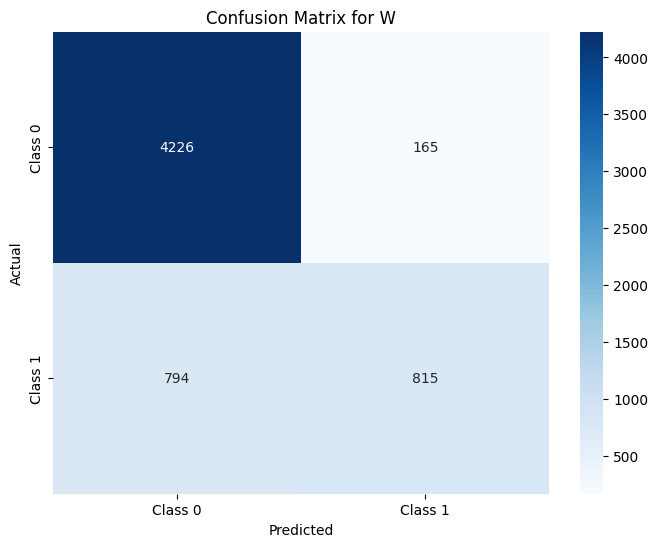

In [538]:
if debug:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_w_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for W')
    plt.show()

In [539]:
print("This is q_W_given_ZA for all possible Z and A")
q_W_given_ZA = get_probabilities(model_q_W, Z_target, A_target)
q_W_given_ZA

This is q_W_given_ZA for all possible Z and A


array([[[0.21393855, 0.78606145],
        [0.35450523, 0.64549477],
        [0.20473405, 0.79526595]],

       [[0.89375173, 0.10624827],
        [0.94436507, 0.05563493],
        [0.88835337, 0.11164663]]])

In [540]:
print("Step 3 done")

Step 3 done


In [541]:
# Now we extract q_W_given_ZA for specific a
print("This is q_W_given_ZA for all possible Z but for a specific A = a")
q_W_given_ZA_specific_a = q_W_given_ZA[:, specific_a_index, :]
q_W_given_ZA_specific_a

This is q_W_given_ZA for all possible Z but for a specific A = a


array([[0.21393855, 0.78606145],
       [0.89375173, 0.10624827]])

In [542]:
if debug:
    p_W_given_epsilon

In [543]:
if debug:    
    print(p_W_given_epsilon.shape)
    print(q_W_given_ZA_specific_a.shape)

(2, 2)
(2, 2)


In [544]:
# TODO: CHECK IF TRANSPOSES NEEDED ETC
# We solve the linear equation by least squares
q_epsilon_given_Z_and_A, _, _, _ = np.linalg.lstsq(p_W_given_epsilon, q_W_given_ZA_specific_a, rcond=None) 

In [545]:
print("Solve the linear equation q(W|Z,a) = p(W|\Epsilon)q(\Epsilon | Z,a) by least squares")
q_epsilon_given_Z_and_A #note I'm getting a negative value here

Solve the linear equation q(W|Z,a) = p(W|\Epsilon)q(\Epsilon | Z,a) by least squares


array([[ 0.10525838,  0.90912858],
       [ 1.11036531, -0.1092734 ]])

In [546]:
print("Step 4 done")

Step 4 done


In [547]:
if debug:
    A_target[:5]

In [548]:
if debug:
    Z_target[:5]

In [549]:
# # Convert the list of tensors to a list of binary labels
# binary_labels_target_Z = [tensor_to_binary(t) for t in Z_target]

# # Convert to numpy array (optional)
# binary_labels_target_array_Z = np.array(binary_labels_target_Z)

# Convert the list of tensors to a list of binary labels
binary_labels_target_Z = [tensor_to_binary(t) for t in Z_train_target]

# Convert to numpy array (optional)
binary_labels_target_array_Z = np.array(binary_labels_target_Z)

In [550]:
if debug:
    binary_labels_target_array_Z

In [551]:
# smote = SMOTE(random_state=42)
# A_train_resampled, Z_train_resampled = smote.fit_resample(A_target, binary_labels_target_array_Z)

# class_weights = {
#     0: 1 / np.sum(binary_labels_target_array_Z == 0),
#     1: 1 / np.sum(binary_labels_target_array_Z == 1)
# }


# Train model to estimate q(Z|a)
model_q_Z = SklearnLogisticRegression(max_iter=1000)#, class_weight = class_weights)
model_q_Z.fit(A_train_target, binary_labels_target_array_Z)

# model_q_Z = SklearnLogisticRegression(max_iter=1000)#, class_weight = class_weights)
# model_q_Z.fit(A_target, binary_labels_target_array_Z)

# model_q_Z.fit(A_train_resampled, Z_train_resampled)

LogisticRegression(max_iter=1000)

In [552]:
if debug:
    A_target[:5]

In [553]:
Z_train_pred_target = model_q_Z.predict(A_train_target)
if debug:
    print("Z_target_pred",Z_train_pred_target)

Z_train_true_target = Z_train_target
accuracy_Z_train_target = np.mean(Z_train_pred_target == binary_labels_target_array_Z)
print(f"Accuracy of model on training set: {accuracy_Z_train_target:.4f}") 

Z_target_pred [0 0 0 ... 0 0 0]
Accuracy of model on training set: 0.7353


In [554]:
Z_train_pred_target.sum()

544

In [555]:
cm_z_target = confusion_matrix(binary_labels_target_array_Z, model_q_Z.predict(A_train_target))
if debug:
    print("Classification Report for Z:")
    print(classification_report(binary_labels_target_array_Z, model_q_Z.predict(A_train_target)))

Classification Report for Z:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      4406
           1       0.51      0.17      0.26      1594

    accuracy                           0.74      6000
   macro avg       0.63      0.56      0.55      6000
weighted avg       0.69      0.74      0.68      6000



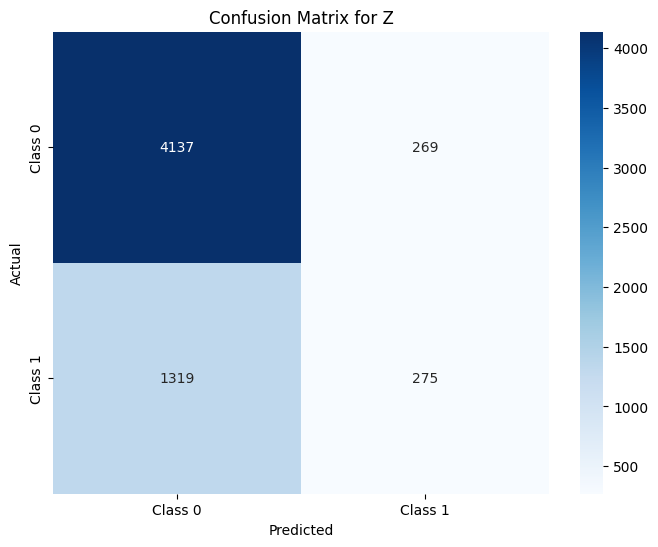

In [556]:
if debug:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_z_target, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Z')
    plt.show()

Z_test_pred_target [0 0 0 ... 0 0 0]
Accuracy of model on test set: 0.7175
Classification Report for Z:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1415
           1       0.55      0.20      0.29       585

    accuracy                           0.72      2000
   macro avg       0.64      0.57      0.56      2000
weighted avg       0.68      0.72      0.67      2000



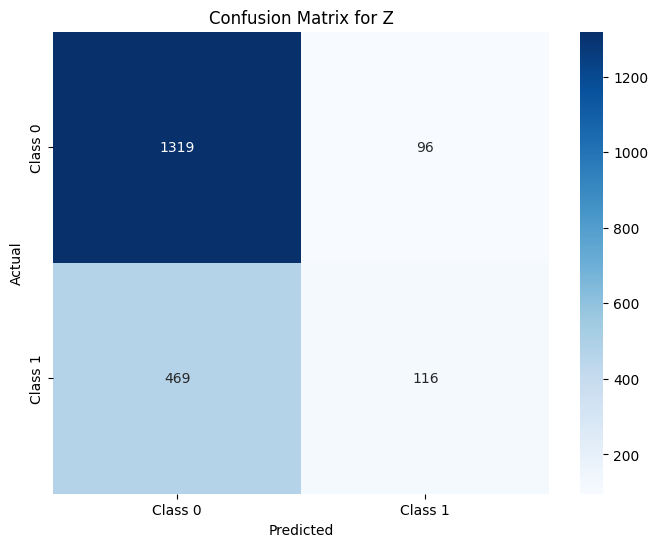

In [557]:
Z_test_pred_target = model_q_Z.predict(A_test_target)
print("Z_test_pred_target",Z_test_pred_target)

Z_test_true_target = Z_test_target

# Convert the list of tensors to a list of binary labels
binary_labels_target_Z_test = [tensor_to_binary(t) for t in Z_test_target]

# Convert to numpy array (optional)
binary_labels_target_array_Z_test = np.array(binary_labels_target_Z_test)

accuracy_Z_test_target = np.mean(Z_test_pred_target == binary_labels_target_array_Z_test)
if debug:
    print(f"Accuracy of model on test set: {accuracy_Z_test_target:.4f}") 

cm_z_target_test = confusion_matrix(binary_labels_target_array_Z_test, model_q_Z.predict(A_test_target))
if debug:
    print("Classification Report for Z:")
    print(classification_report(binary_labels_target_array_Z_test, model_q_Z.predict(A_test_target)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_z_target_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Z')
    plt.show()

In [558]:
print("Step 5 done")

Step 5 done


In [559]:
if debug:
    p_Y_given_epsilon

In [560]:
if debug:
    q_epsilon_given_Z_and_A

In [561]:
# Assuming A_source is a list of tensors
A_source_np = np.array([a.numpy() for a in A_source])

# Find unique rows in A_source_np
unique_A = np.unique(A_source_np, axis=0)

if debug:
    # Print the number of unique rows
    print(f"Number of distinct entries in A_source: {len(unique_A)}")

    # Optionally, print the distinct entries
    print("Distinct entries in A_source:")
    print(unique_A)

Number of distinct entries in A_source: 3
Distinct entries in A_source:
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [562]:

# Assuming A_source and Z_source are lists of tensors
A_source_np = np.array([a.numpy() for a in A_source])
Z_source_np = np.array([z.numpy() for z in Z_source])

if debug:
    # Check shapes to understand the data structure
    print("Shape of A_source_np:", A_source_np.shape)
    print("Shape of Z_source_np:", Z_source_np.shape)

# Ensure Z_source_np is flattened correctly if it's one-hot encoded or needs any transformation
# For example, if Z_source is 2D and needs to be combined into a single label per row:
if Z_source_np.shape[1] == 2:
    Z_source_np = np.argmax(Z_source_np, axis=1)

# Find unique entries in A_source
unique_A = np.unique(A_source_np, axis=0)

# Initialize a matrix to count occurrences of each A entry for Z = 0 and Z = 1
count_matrix = np.zeros((len(unique_A), 2))

# Populate the count matrix
for i, unique_a in enumerate(unique_A):
    for z_val in [0, 1]:
        count_matrix[i, z_val] = np.sum((A_source_np == unique_a).all(axis=1) & (Z_source_np == z_val))

# Convert the matrix to a DataFrame for better visualization
unique_A_labels = ['A' + str(i) for i in range(len(unique_A))]
count_df = pd.DataFrame(count_matrix, index=[str(list(a)) for a in unique_A], columns=['Z=0', 'Z=1'])

if debug:
    # Display the DataFrame
    print(count_df)


Shape of A_source_np: (10000, 3)
Shape of Z_source_np: (10000, 2)
                    Z=0    Z=1
[0.0, 0.0, 1.0]  3776.0  726.0
[0.0, 1.0, 0.0]   844.0  126.0
[1.0, 0.0, 0.0]  3811.0  717.0


In [563]:
if debug:
    Z_target[:5]

In [564]:

# # Convert lists of tensors to numpy arrays
# Z = np.array([z.numpy() for z in Z_target])
# A = np.array([a.numpy() for a in A_target])

# num_Z = Z.shape[1]
# num_A = A.shape[1]

# # Generate all possible one-hot vectors for Z and A
# possible_Z = np.eye(num_Z)
# possible_A = np.eye(num_A)

# probabilities = []

# for z in possible_Z:
#     for a in possible_A:
#         ZA = np.hstack((z.reshape(1, -1), a.reshape(1, -1)))
#         # Flatten ZA for the MLPClassifier
#         ZA_flat = ZA.flatten().reshape(1, -1)
#         prob = model.predict_proba(ZA_flat)[0]
#         probabilities.append(prob)

# probabilities = np.array(probabilities).reshape((num_Z, num_A, 2))

# return probabilities

# q_Z_given_A = get_probabilities(model_q_Z, A_target, Z_target)

In [565]:
print("This is p(Y|\epsilon,a)")
print(p_Y_given_epsilon)
print("")

print("This is q(\epsilon|Z,a)")
print(q_epsilon_given_Z_and_A)
print("")

one_hot_specific_a = np.eye(len(A_source[0]))[specific_a_index].reshape(1, -1)
q_Z_given_A = model_q_Z.predict_proba(one_hot_specific_a)
print("This is q(Z|a)")
print(q_Z_given_A)

This is p(Y|\epsilon,a)
[[0.93292302 0.05359653]
 [0.5160179  0.47603838]]

This is q(\epsilon|Z,a)
[[ 0.10525838  0.90912858]
 [ 1.11036531 -0.1092734 ]]

This is q(Z|a)
[[0.75039109 0.24960891]]


In [566]:
q_Y_given_A = p_Y_given_epsilon@(q_epsilon_given_Z_and_A@q_Z_given_A.T)
print("q_Y_given_a:", q_Y_given_A)

q_Y_given_a: [[0.32858712]
 [0.54151069]]


In [567]:
q_Y_given_a_normalised = q_Y_given_A / np.sum(q_Y_given_A)
print("q_Y_given_a_normalised:", q_Y_given_a_normalised)

q_Y_given_a_normalised: [[0.37764389]
 [0.62235611]]


In [568]:
# BASELINE METHODS #

In [569]:
###### COVARIATE SHIFT #####

In [570]:
"""Implementation of covariate shift adaptation method. """

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import random_projection as r_proj


def convert_data_y2d(source, target):
    source_y = np.zeros_like(source["Y"])
    target_y = np.ones_like(target["Y"])

    return {
        "X": np.concatenate([source["X"], target["X"]], axis=0),
        "Y": np.concatenate([source_y, target_y], axis=0).ravel(),
    }


class COVAR:
    """Covariate shift adaptation."""

    def __init__(self, alpha=1.0, kernel="rbf", proj_dim=16):
        self.source_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_covar_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.proj_dim = proj_dim

    def fit(self, source_train, target_train):
        domain_d = convert_data_y2d(source_train, target_train)
        proj = r_proj.GaussianRandomProjection(
            n_components=self.proj_dim, random_state=0
        ).fit(domain_d["X"])
        d_x = LogisticRegression(random_state=0)
        d_x.fit(proj.transform(domain_d["X"]), domain_d["Y"])

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(source_train["X"]))[:, 1]
        source_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit source model
        self.source_covar_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights
        q_x_train = d_x.predict_proba(proj.transform(target_train["X"]))[:, 0]
        target_sample_weight_train = q_x_train / (1.0 - q_x_train + 1e-3)

        # Fit target model
        self.target_covar_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_covar_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_covar_model.predict(test_data["X"])

In [571]:
print(len(Z_source))
print(len(Y_source))
print(len(Z_train_source))
print(len(Y_train_source))

10000
10000
6000
6000


In [572]:
np.array([tensor.item() for tensor in Y_test_source]).astype(int).sum()

1672

In [573]:
source_train = {"X": Z_train_source, "Y": Y_train_source}
target_train = {"X": Z_train_target, "Y": Y_train_target}
test_data = {"X": Z_test_source}

In [574]:
# Initialize the model
covar_model = COVAR(alpha=1.0, kernel="rbf", proj_dim=16)

# Fit the model to the training data
covar_model.fit(source_train, target_train)

# Make predictions on the test data from the source domain
predictions = covar_model.predict(test_data)

print("Predictions using source model:", predictions)

/Users/rickcollins64/opt/anaconda3/envs/MV00/lib/python3.9/site-packages/sklearn/random_projection.py:409: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(


Predictions using source model: [0.93372129 0.43652572 0.82862557 ... 0.93372129 0.80515792 0.43652572]


In [575]:
# convert probabilities to predictions
predictions_source_covar = (predictions >= 0.5).astype(int)

binary_labels_test_source_covar = np.array([tensor.item() for tensor in Y_test_source]).astype(int)

print(predictions_source_covar)
print(binary_labels_test_source_covar)

[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 1]


Accuracy of model on target training set: 0.8580
Classification Report for Z:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       328
           1       0.91      0.92      0.92      1672

    accuracy                           0.86      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.85      0.86      0.86      2000



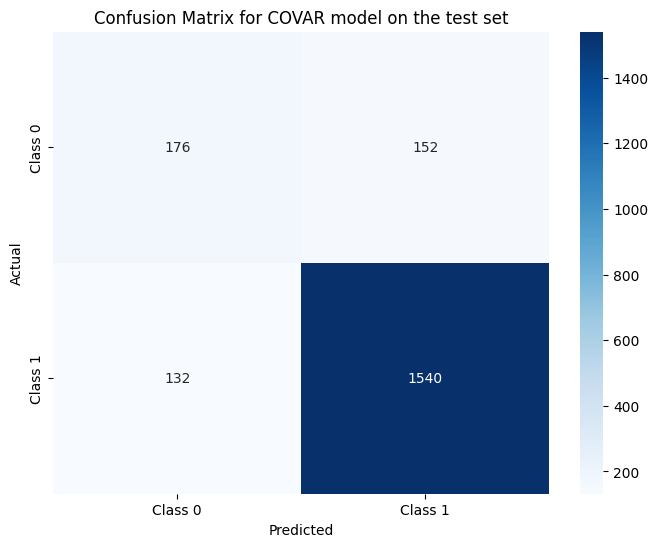

In [576]:
# Predict on the target domain training set using the target model
# Z_train_pred_source = covar_model.predict_target({"X": Z_train_target})

# Assuming binary_labels_target_array_Z contains the true labels for Z_train_target
accuracy_covar = np.mean(binary_labels_test_source_covar == predictions_source_covar)
print(f"Accuracy of model on target training set: {accuracy_covar:.4f}")

# Compute confusion matrix and classification report
cm_covar_source = confusion_matrix(binary_labels_test_source_covar, predictions_source_covar)
print("Classification Report for Z:")
print(classification_report(binary_labels_test_source_covar, predictions_source_covar))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_covar_source, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for COVAR model on the test set')
plt.show()

In [577]:
# LABEL SHIFT #

In [578]:
"""Implementation of label shift adaptation method."""

# Author: Nicole Chiou <nicchiou@stanford.edu>, Katherine Tsai <kt14@illinois.edu>
# MIT License


import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize
import cvxpy as cp
import scipy


class ConLABEL:
    """
    Continuous label shift adaptation.

    Zhang, K., Schölkopf, B., Muandet, K., & Wang, Z. (2013, May).
    Domain adaptation under target and conditional shift.
    In International conference on machine learning (pp. 819-827). PMLR.
    """

    def __init__(self, lam, bp, alpha, kernel, kernel2):
        self.lam = lam
        self.bp = bp
        self.kernel = kernel
        self.label_model = KernelRidge(alpha=alpha, kernel=kernel2)

    def fit(self, source_data, target_x):

        # Learn the weight
        K_Y = self.kernel(source_data["Y"], source_data["Y"])

        K_X = self.kernel(source_data["X"], source_data["X"])
        m1 = K_X.shape[0]

        inv_KY = scipy.linalg.solve(K_Y + self.lam * np.eye(m1), np.eye(m1))
        inv_KY_KY = np.einsum("ij,jk->ik", inv_KY, K_Y)

        K_X1X2 = self.kernel(source_data["X"], target_x)
        m2 = K_X1X2.shape[1]
        A = inv_KY_KY.T @ K_X @ inv_KY_KY

        B = K_X1X2.T @ inv_KY_KY
        B = (m1 / m2) * B
        B = np.sum(B, axis=0)
        G = np.eye(m1)
        G2 = -np.eye(m1)
        x = cp.Variable(m1)
        h = self.bp * np.ones(m1)
        h2 = np.zeros(m1)
        C = np.ones(m1)
        eps = self.bp * np.sqrt(m1) / 4
        print("start fitting")
        prob = cp.Problem(
            cp.Minimize((1 / 2) * cp.quad_form(x, A) + B.T @ x),
            [G @ x <= h, G2 @ x <= h2, C @ x <= eps + m1, -C @ x <= -m1 + eps],
        )

        prob.solve()
        print("finished")
        print(f"Problem status {prob.status}")
        beta = np.array(x.value)
        idx = np.where(beta < 0)[0]
        beta[idx] = 0
        beta = normalize(beta[:, np.newaxis]).squeeze()
        self.label_model.fit(
            source_data["X"],
            source_data["Y"],
            sample_weight=beta,
        )

    def predict(self, test_data):
        return self.label_model.predict(test_data)


class LABEL:
    """
    implementation of label shift adaptation method.
    """

    def __init__(self, alpha, kernel="rbf", kernel2="gaussian", bandwidth=1):
        self.source_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)
        self.target_kde = KernelDensity(kernel=kernel2, bandwidth=bandwidth)

        self.source_label_model = KernelRidge(alpha=alpha, kernel=kernel)
        self.target_label_model = KernelRidge(alpha=alpha, kernel=kernel)

    def fit(self, source_train, source_val, target_train):
        self.source_kde.fit(source_val["Y"])
        self.target_kde.fit(target_train["Y"])

        # Compute sample weights q(Y)/p(Y)
        log_q_y = self.target_kde.score_samples(source_train["Y"])
        log_p_y = self.source_kde.score_samples(source_train["Y"])

        source_sample_weight_train = np.exp(log_q_y - log_p_y)

        # Fit source model
        self.source_label_model.fit(
            source_train["X"],
            source_train["Y"],
            sample_weight=source_sample_weight_train,
        )

        # Compute sample weights p(Y)/q(Y)
        target_sample_weight_train = np.exp(log_p_y - log_q_y)

        # Fit target model
        self.target_label_model.fit(
            target_train["X"],
            target_train["Y"],
            sample_weight=target_sample_weight_train,
        )

    def predict(self, test_data):
        return self.source_label_model.predict(test_data["X"])

    def predict_target(self, test_data):
        return self.target_label_model.predict(test_data["X"])

In [579]:
# Prepare the data (ensure your data is correctly formatted)
source_train = {"X": Z_train_source, "Y": Y_train_source}
source_val = {"Y": Y_val_source}
target_train = {"X": Z_train_target, "Y": Y_train_target}
test_data_source = {"X": Z_test_source}
binary_labels_test_source = np.array([tensor.item() for tensor in Y_test_source])

# Reshape Y values to 2D arrays
source_val["Y"] = source_val["Y"].reshape(-1, 1)
target_train["Y"] = target_train["Y"].reshape(-1, 1)
source_train["Y"] = source_train["Y"].reshape(-1, 1)
binary_labels_test_source = binary_labels_test_source.reshape(-1, 1)

# Initialize the LABEL model
label_model = LABEL(alpha=1.0, kernel="rbf", kernel2="gaussian", bandwidth=1)

# Fit the model to the training data
label_model.fit(source_train, source_val, target_train)

# Get the predicted probabilities from the LABEL model on the source domain test data
prob_predictions_source = label_model.predict(test_data_source)
# Convert probabilities to class labels using a threshold of 0.5
predictions_source = (prob_predictions_source >= 0.5).astype(int)
print("Predictions using LABEL model on source test data:", predictions_source)

# Ensure both are the same data type for comparison
binary_labels_test_source = binary_labels_test_source.astype(int)

# Evaluate the LABEL model on the source domain test data
accuracy_label = accuracy_score(binary_labels_test_source, predictions_source)
print(f"Accuracy of LABEL model on source test data: {accuracy_label:.4f}")

# Compute confusion matrix and classification report for LABEL model
cm_label_source = confusion_matrix(binary_labels_test_source, predictions_source)
print("Classification Report for LABEL model on source test data:")
print(classification_report(binary_labels_test_source, predictions_source))

# Plot the confusion matrix for LABEL model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_label_source, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LABEL model on source test data')
plt.show()

AttributeError: 'list' object has no attribute 'reshape'